# 1. Imports and Data Loading.

In [9]:
from basic_functions import data_load
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
X_train_raw = data_load("data/X_train.csv")
y_train = data_load("data/y_train_clustered.csv")

Data loaded!
Data loaded!


# 2. Feature Importance

## 2.1 Unique Values

Dataframe with count of unique values for each Feature.

In [11]:
counts = {}
for key in X_train_raw.columns:
    counts[key] = X_train_raw[key].nunique()
df_counts = pd.DataFrame(list(counts.items()), columns=["Feature", "UniqueValues"])

## 2.2 MI-Scores

MI-Scores for each Feature.

In [12]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Nur auf Trainingsdaten!
mi_scores = mutual_info_classif(X_train_raw, y_train, discrete_features=True, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train_raw.columns)
mi_df = mi_series.reset_index()
mi_df.columns = ["Feature", "MI_Score"]

c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


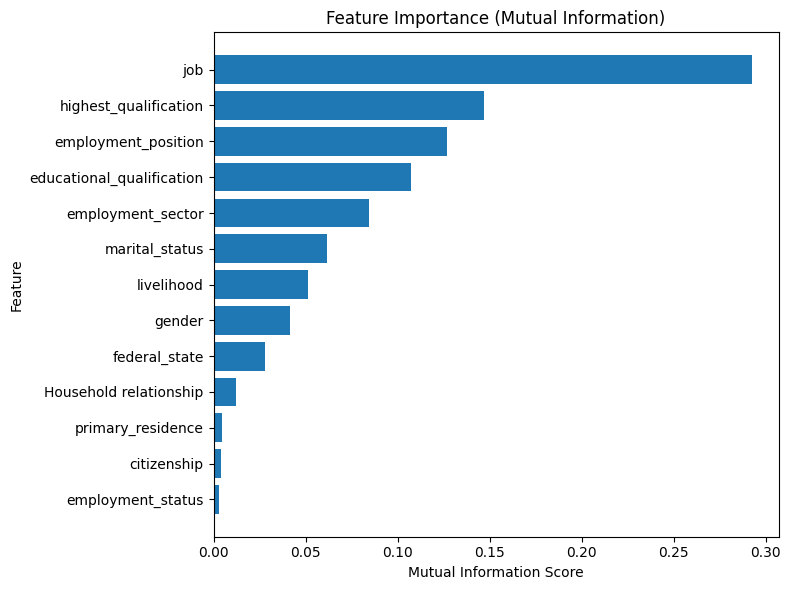

In [13]:
import matplotlib.pyplot as plt


mi_df_sorted = mi_df.sort_values(by="MI_Score", ascending=True)


plt.figure(figsize=(8, 6))
plt.barh(mi_df_sorted["Feature"], mi_df_sorted["MI_Score"])
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Mutual Information)")
plt.tight_layout()
plt.show()


## 2.3 Chi2 and P-Value

Chi2-Scores and P-Values for each Feature.

In [14]:
from sklearn.feature_selection import chi2
chi2_scores, p_values = chi2(X_train_raw, y_train)
chi2_df = pd.DataFrame({
    "Feature": X_train_raw.columns,
    "Chi2 Score": chi2_scores.round(2),
    "p-value": p_values.round(3)
}).sort_values(by="Chi2 Score", ascending=False)

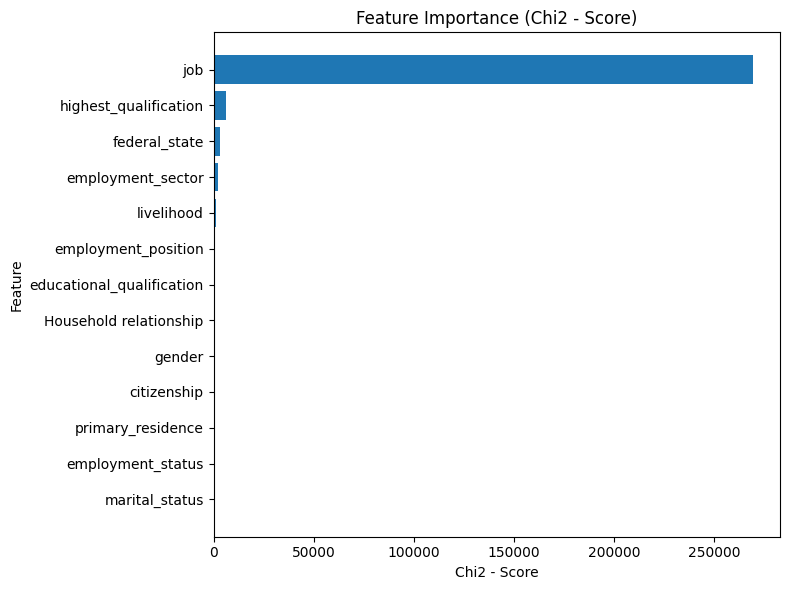

In [15]:
import matplotlib.pyplot as plt


chi2_df_sorted = chi2_df.sort_values(by="Chi2 Score", ascending=True)


plt.figure(figsize=(8, 6))
plt.barh(chi2_df_sorted["Feature"], chi2_df_sorted["Chi2 Score"])
plt.xlabel("Chi2 - Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Chi2 - Score)")
plt.tight_layout()
plt.show()

## 2.4 Metric Dataframe

Combination of the metrics.

In [16]:
df_combined = df_counts.merge(mi_df, on="Feature", how="left")
df_combined = df_combined.merge(chi2_df, on="Feature", how="left")

final Dataframe featuring the feature-importance-metrics.

In [17]:
df_combined.sort_values(by="MI_Score", ascending=False)

,Feature,UniqueValues,MI_Score,Chi2 Score,p-value
6,job,103,0.292287,269310.50,0.000
10,highest_qualification,9,0.147100,6121.31,0.000
7,employment_position,10,0.126701,414.05,0.000
9,educational_qualification,9,0.107328,408.52,0.000
5,employment_sector,21,0.084281,1991.60,0.000
3,marital_status,7,0.061736,2.25,0.895
8,livelihood,9,0.051176,999.29,0.000
1,gender,2,0.041752,132.33,0.000
0,federal_state,2,0.028219,3226.02,0.000
12,Household relationship,7,0.012148,161.77,0.000


# 3. Baseline Modell Pipeline

## 3.1 Model (Naive Bayes) Pipeline

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer


pipe_nb = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("nb", CategoricalNB())
])

CV Definition

In [19]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_macro": make_scorer(f1_score, average="macro"),
    "neg_log_loss": "neg_log_loss"
}

In [20]:
def calculate_cv(pipeline, X, y, cv, scoring, show_results = True):

    cv_results   = cross_validate(pipeline, X.astype("category"), y, cv=cv, scoring=scoring)
    
    if show_results:
        for metric in scoring.keys():
            mean = cv_results[f"test_{metric}"].mean()
            std = cv_results[f"test_{metric}"].std()
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

    return cv_results

## 3.2 Baseline Test

In [21]:
cv_results = calculate_cv(pipeline=pipe_nb, X=X_train_raw, y=y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.4179 ± 0.0048
f1_macro: 0.3686 ± 0.0059
neg_log_loss: -1.5494 ± 0.0210


# 4 Feature Engineering

In [22]:
def compute_feature_metrics(X, y):

    from sklearn.feature_selection import mutual_info_classif
    from sklearn.feature_selection import chi2
    import pandas as pd

     # MI
    mi_scores = mutual_info_classif(X, y, discrete_features=True, random_state=42)
    mi_df = pd.DataFrame({
        "Feature": X.columns,
        "MI_Score": mi_scores
    })

    # Chi²
    chi2_scores, p_values = chi2(X, y)
    chi2_df = pd.DataFrame({
        "Feature": X.columns,
        "Chi2_Score": chi2_scores.round(2),
        "p-value": p_values.round(3)
    })

    # Unique Values
    unique_counts = pd.DataFrame({
        "Feature": X.columns,
        "UniqueValues": [X[col].nunique() for col in X.columns]
    })

    # Merge zu einer Tabelle
    metrics_df = unique_counts.merge(mi_df, on="Feature").merge(chi2_df, on="Feature")
    metrics_df= metrics_df.sort_values(by="MI_Score", ascending=False)
    return metrics_df    

## 4.1 Job --> major job , minor job

Job is encoded (ISCO-88) -> first digit describes major job category.

In [23]:
X_train_raw["job_major"] = X_train_raw["job"].astype(str).str[0]
X_train_raw["job_minor"] = X_train_raw["job"].astype(str).str[:2]

In [24]:
metrics_df = compute_feature_metrics(X_train_raw, y_train["income"])
print(metrics_df)

                      Feature  UniqueValues  MI_Score  Chi2_Score  p-value
6                         job           103  0.292287   269310.50    0.000
14                  job_minor            27  0.204230    26867.56    0.000
13                  job_major             9  0.161339     2819.93    0.000
10      highest_qualification             9  0.147100     6121.31    0.000
7         employment_position            10  0.126701      414.05    0.000
9   educational_qualification             9  0.107328      408.52    0.000
5           employment_sector            21  0.084281     1991.60    0.000
3              marital_status             7  0.061736        2.25    0.895
8                  livelihood             9  0.051176      999.29    0.000
1                      gender             2  0.041752      132.33    0.000
0               federal_state             2  0.028219     3226.02    0.000
12     Household relationship             7  0.012148      161.77    0.000
11          primary_resid

## 4.2 Cross Features

In [25]:
top_features = [
    "job_major", "highest_qualification", "employment_position",
    "educational_qualification", "employment_sector",
    "marital_status", "livelihood", "gender", "federal_state"
]

cross_df = pd.DataFrame(index=X_train_raw.index)  # leeres DF für Cross Features

for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        col_name = f"{top_features[i]}__{top_features[j]}"
        cross_df[col_name] = (
            X_train_raw[top_features[i]].astype(str) + "_" + X_train_raw[top_features[j]].astype(str)
        )

cross_df_metrics = compute_feature_metrics(cross_df, y_train["income"])


In [26]:
print(cross_df_metrics)

                                             Feature  UniqueValues  MI_Score  \
3                       job_major__employment_sector           150  0.305132   
10          highest_qualification__employment_sector           152  0.285062   
1                     job_major__employment_position            73  0.268813   
16            employment_position__employment_sector           128  0.256163   
4                          job_major__marital_status            49  0.251319   
0                   job_major__highest_qualification            70  0.248905   
8         highest_qualification__employment_position            67  0.241929   
21      educational_qualification__employment_sector           145  0.238501   
11             highest_qualification__marital_status            49  0.234969   
2               job_major__educational_qualification            74  0.230589   
6                                  job_major__gender            18  0.225495   
15    employment_position__educational_q

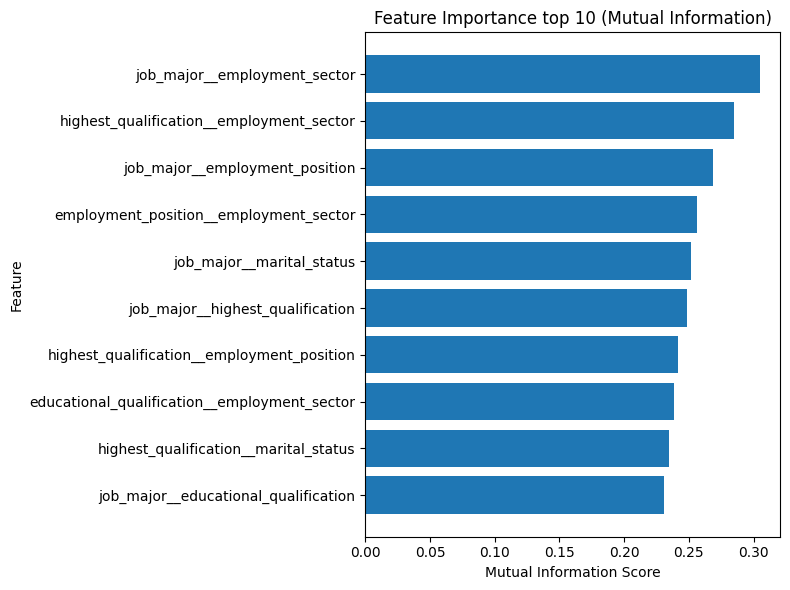

In [27]:
import matplotlib.pyplot as plt


cross_df_metrics_sorted = cross_df_metrics.sort_values(by="MI_Score", ascending=True)


plt.figure(figsize=(8, 6))
plt.barh(cross_df_metrics_sorted["Feature"].tail(10), cross_df_metrics_sorted["MI_Score"].tail(10))
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Feature Importance top 10 (Mutual Information)")
plt.tight_layout()
plt.show()

# 5. Final Features and evaluation

## 5.1 Pipeline Integration

In [28]:
cross_feature_pairs = [
    ("job_major", "employment_sector"),
    ("job_major", "employment_position"),
    ("job_major", "highest_qualification"),
    ("job_major", "marital_status"),
    ("job_major", "federal_state"),
    ("job_major", "gender"),
    ("highest_qualification", "livelihood")
]

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

class CrossFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, pairs):
        self.pairs = pairs

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        for f1, f2 in self.pairs:
            col_name = f"{f1}__{f2}"
            X_[col_name] = X_[f1].astype(str) + "_" + X_[f2].astype(str)
        return X_



In [30]:
_ = calculate_cv(pipeline=pipe_nb, X= X_train_raw, y = y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.3915 ± 0.0067
f1_macro: 0.3526 ± 0.0094
neg_log_loss: -1.9319 ± 0.0474


In [31]:
for pair in cross_feature_pairs:

    pipe_nb_fe = Pipeline(steps=[
    ("cross_feats", CrossFeatures([pair])),
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("nb", CategoricalNB())
])
    
    print(f"Pair: {pair}")
    
    cv_results = calculate_cv(pipeline=pipe_nb_fe, X=X_train_raw, y=y_train["income"], cv=cv, scoring=scoring)

Pair: ('job_major', 'employment_sector')
accuracy: 0.3850 ± 0.0101
f1_macro: 0.3519 ± 0.0129
neg_log_loss: -2.1971 ± 0.0609
Pair: ('job_major', 'employment_position')
accuracy: 0.3901 ± 0.0096
f1_macro: 0.3568 ± 0.0095
neg_log_loss: -2.1792 ± 0.0630
Pair: ('job_major', 'highest_qualification')
accuracy: 0.3796 ± 0.0076
f1_macro: 0.3428 ± 0.0109
neg_log_loss: -2.1910 ± 0.0536
Pair: ('job_major', 'marital_status')
accuracy: 0.3888 ± 0.0083
f1_macro: 0.3565 ± 0.0090
neg_log_loss: -2.1456 ± 0.0623
Pair: ('job_major', 'federal_state')
accuracy: 0.3783 ± 0.0094
f1_macro: 0.3458 ± 0.0105
neg_log_loss: -2.1844 ± 0.0622
Pair: ('job_major', 'gender')
accuracy: 0.3801 ± 0.0120
f1_macro: 0.3469 ± 0.0137
neg_log_loss: -2.1842 ± 0.0625
Pair: ('highest_qualification', 'livelihood')
accuracy: 0.3941 ± 0.0061
f1_macro: 0.3544 ± 0.0079
neg_log_loss: -2.0738 ± 0.0428


--> no Improvement. 

## 5.2 Random Forest Pipeline

In [32]:
from sklearn.ensemble import RandomForestClassifier


random_forest = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)


In [33]:
pipe_rf = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("rf", random_forest)
])

In [34]:
_ = calculate_cv(pipeline=pipe_rf, X= X_train_raw, y = y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.6923 ± 0.0043
f1_macro: 0.6844 ± 0.0073
neg_log_loss: -1.1856 ± 0.0667


In [35]:
for pair in cross_feature_pairs:

    pipe_rf_oe = Pipeline(steps=[
    ("cross_feats", CrossFeatures([pair])),
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("rf", random_forest)
])
    
    print(f"Pair: {pair}")
    
    cv_results = calculate_cv(pipeline=pipe_rf_oe, X=X_train_raw, y=y_train["income"], cv=cv, scoring=scoring)

Pair: ('job_major', 'employment_sector')
accuracy: 0.6923 ± 0.0047
f1_macro: 0.6837 ± 0.0089
neg_log_loss: -1.2135 ± 0.0303
Pair: ('job_major', 'employment_position')
accuracy: 0.6927 ± 0.0060
f1_macro: 0.6841 ± 0.0092
neg_log_loss: -1.2381 ± 0.0565
Pair: ('job_major', 'highest_qualification')
accuracy: 0.6911 ± 0.0049
f1_macro: 0.6830 ± 0.0099
neg_log_loss: -1.2261 ± 0.0624
Pair: ('job_major', 'marital_status')
accuracy: 0.6914 ± 0.0059
f1_macro: 0.6835 ± 0.0093
neg_log_loss: -1.2215 ± 0.0472
Pair: ('job_major', 'federal_state')
accuracy: 0.6918 ± 0.0057
f1_macro: 0.6839 ± 0.0104
neg_log_loss: -1.2352 ± 0.0335
Pair: ('job_major', 'gender')
accuracy: 0.6914 ± 0.0044
f1_macro: 0.6837 ± 0.0076
neg_log_loss: -1.2420 ± 0.0919
Pair: ('highest_qualification', 'livelihood')
accuracy: 0.6922 ± 0.0046
f1_macro: 0.6841 ± 0.0096
neg_log_loss: -1.2477 ± 0.0644


--> Cross Feature Tuning does not improve the performance of random Forest or Naive Bayes classifier.